_This notebook walks through data integration, model building, and optimization. The end result is a curated summary of information that can be used to maximize cost savings for renewable energy use._

# Environment Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sundial

/Users/ryanstoddard/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ryanstoddard/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Getting the Data

## Download files

In [ ]:
TBD?

## Integrate data 

In [ ]:
TBD?

# Building Independent Models

## Battery Degradation

In [54]:
# Set battery statics
usage_kWhr = 8
t_start    = 18   # 6:00pm, sun goes down
t_final    = 22   # 10:00pm, this means battery stops at 10:00pm, not 10:59
date       = 343  # Dec 9th
cap_kWhr   = 100 # battery capacity
cost_mult  = 10*cap_kWhr # cost scales with capacity, adjust to make relavent if needed

# Compute battery degradation cost per hour.
battery_cph = sundial.battery_model.bat_price_per_hour(usage_kWhr, 
                                                       t_start,
                                                       t_final,
                                                       date,
                                                       cap_kWhr,
                                                       cost_mult)

print(battery_cph)

[ 0.00944617  0.00944617  0.00944617  0.00944617  0.00944617  0.00944617
  0.00944617  0.00944617  0.00944617  0.00944617  0.00944617  0.00944617
  0.00944617  0.00944617  0.00944617  0.00944617  0.00944617  0.00944617
  0.02017978  0.02017978  0.02017978  0.02017978  0.00944617  0.00944617]


## Energy Price

In [5]:
epm = sundial.price_model.EnergyPriceModel()
price_cph = epm.test_model("2016-12-08", "SVM_rbf")

print(price_cph)

[ 32.19015215  36.43083971  31.89780703  28.93836475  31.43631105
  31.00931086  29.58275531  29.1197807   28.57548864  30.70826625
  32.90944406  32.52323928  28.02839139  25.80837985  24.78875951
  29.32269832  21.13044295  19.29652082  47.3891587   31.71214353
  40.31117218  24.71340464  56.25528621  43.67043595]


/Users/ryanstoddard/anaconda/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVR from version 0.19.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Solar Output

In [8]:
pv_output_cph = sundial.pv_model.pv_output_cph() #(month,day)
pv_output_cph

array([  31.23777766,   25.70136127,   24.11832116,   24.22678971,
         24.90134954,   23.05957736,   21.1010235 ,   20.26835697,
         26.94026552,   61.74655113,   96.61189875,  144.22862102,
        174.99488429,  218.88510249,  233.92424337,  255.59493782,
        180.68124   ,  147.63222936,   59.95188971,   58.24967259,
         35.74804945,   35.34660503,   28.17380741,   29.64046005])

## Energy Demand

In [7]:
demand_cph = sundial.demand_model.get_demand_cph()

/Users/ryanstoddard/Documents/UW/CSE_586/Project/SunDial/sundial/demand_model/demand_model.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sm_obs["DateTime"] = sm_datetime


## Integrating Cost Models

In [42]:
df = pd.DataFrame({'battery_cph': battery_cph,
                  'price_cph': price_cph,
                  'demand_cph': demand_cph,
                  'pv_out_cph': pv_output_cph})
df['demand_cph'][0] = df['demand_cph'][1]
df['demand_cph'] = df['demand_cph']*10
df['pv_out_cph'] = df['pv_out_cph']*20/250
print(df)

    battery_cph  demand_cph  price_cph  pv_out_cph
0      0.023615    5.817405  32.190152    2.499022
1      0.023615    5.817405  36.430840    2.056109
2      0.023615    5.194910  31.897807    1.929466
3      0.023615    5.023098  28.938365    1.938143
4      0.023615    5.040775  31.436311    1.992108
5      0.023615    5.346059  31.009311    1.844766
6      0.023615    6.401306  29.582755    1.688082
7      0.023615    8.250965  29.119781    1.621469
8      0.023615    8.904444  28.575489    2.155221
9      0.023615    8.226171  30.708266    4.939724
10     0.023615    7.706253  32.909444    7.728952
11     0.023615    7.696674  32.523239   11.538290
12     0.023615    7.564505  28.028391   13.999591
13     0.023615    7.318673  25.808380   17.510808
14     0.023615    7.146019  24.788760   18.713939
15     0.023615    7.284199  29.322698   20.447595
16     0.023615    8.163182  21.130443   14.454499
17     0.023615   10.164198  19.296521   11.810578
18     0.050449   12.429049  47

# Cost Maximization

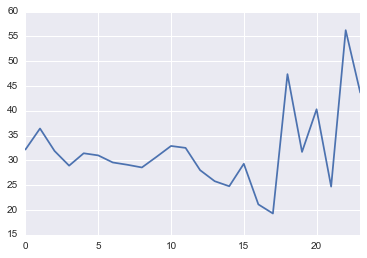

In [20]:
%matplotlib inline

df['price_cph'].plot()

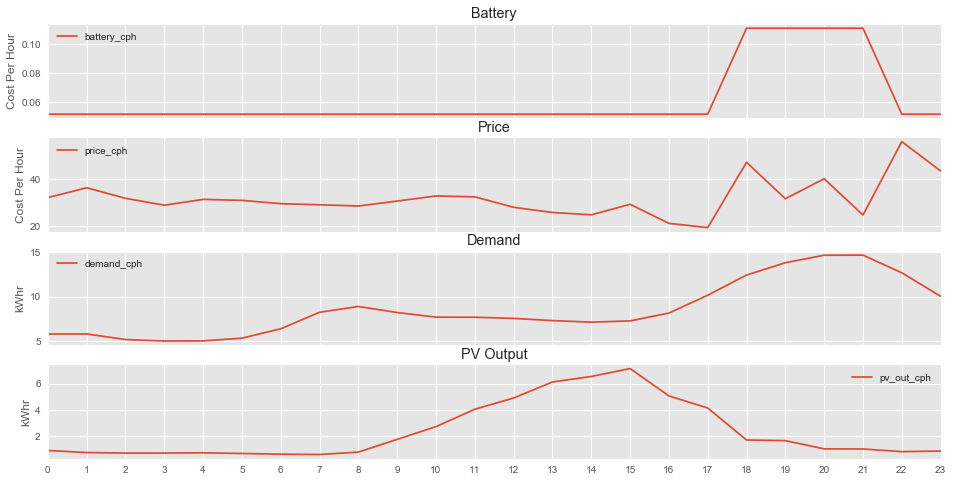

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig, ax = plt.subplots(4, 1, figsize=(16, 8), sharey=False, sharex=True)
plt.xticks(np.arange(0, 24))

df.plot.line(df.index, 'battery_cph', ax=ax[0])
df.plot.line(df.index,'price_cph', use_index=True, ax=ax[1])
df.plot.line(df.index,'demand_cph', ax=ax[2])
df.plot.line(df.index,'pv_out_cph', ax=ax[3])

ax[0].set_title("Battery")
ax[1].set_title("Price")
ax[2].set_title("Demand")
ax[3].set_title("PV Output")

for a in ax:
    a.set_ylabel("Cost Per Hour")
    
ax[2].set_ylabel('kWhr')
ax[3].set_ylabel('kWhr')

## Alternate Cost Scenarios

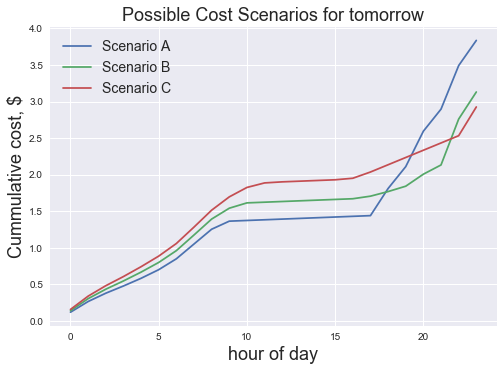

In [65]:
#In scenario A, baseline case where we just don't run the battery. Do this by setting B = 0 and cycles = 0 in battery cost formula:
df['Scenario_A'] = 1 * np.max([(df['price_cph']/1000 * (df['demand_cph'] - df['pv_out_cph'] - 0)),np.zeros(24)],axis=0) + sundial.battery_model.bat_price_per_hour(0,t_start,t_final,date,cap_kWhr,cost_mult)
df['Scenario_A'] = df['Scenario_A'].cumsum()
#In scenario B, we choose to cycle during certain hours input by user:
t_start    = 18   # 6:00pm, sun goes down, USER INPUT
t_final    = 22   #USER INPUT
#also can input rate, as percent per hour, but total in cycle can't exceed max_cap
rate = 0.10 # % of capacity per hour, USER INPUT
usage_kWhr = np.min([cap_kWhr*rate*(t_final-t_start),cap_kWhr])
B = np.zeros(24)
B[t_start:t_final] = usage_kWhr/(t_final-t_start)
PV_balance = usage_kWhr*df['pv_out_cph']/np.sum(df['pv_out_cph']) # Energy taken from PV to charge battery

df['Scenario_B'] = 1 * np.max([(df['price_cph']/1000 * (df['demand_cph'] - (df['pv_out_cph']-PV_balance) - B)),np.zeros(24)],axis=0) + sundial.battery_model.bat_price_per_hour(usage_kWhr,t_start,t_final,date,cap_kWhr,cost_mult)
df['Scenario_B'] = df['Scenario_B'].cumsum()

#In scenario C, we choose to cycle battery during hours when cost exceeds XX
cost_thresh = 40 # [$/MWhr,], USER INPUT
rate = 0.15 # % of capacity per hour, USER INPUT
is_higher = np.nonzero(df['price_cph'] > cost_thresh)
if len(is_higher[0]) > 0:
    t_start = np.min(is_higher)
    t_final = np.max(is_higher) #assume single cycle, even if price momentarily dips below
    usage_kWhr = np.min([cap_kWhr*rate*(t_final-t_start),cap_kWhr])
    B = np.zeros(24)
    B[t_start:t_final] = usage_kWhr/(t_final-t_start)
    PV_balance = usage_kWhr*df['pv_out_cph']/np.sum(df['pv_out_cph']) # Energy taken from PV to charge battery
else:
    usage_kWhr = 0
    B = 0
    PV_balance = 0

df['Scenario_C'] =  1 * np.max([(df['price_cph']/1000 * (df['demand_cph'] - (df['pv_out_cph']-PV_balance) - B)),np.zeros(24)],axis=0) + sundial.battery_model.bat_price_per_hour(usage_kWhr,t_start,t_final,date,cap_kWhr,cost_mult)
df['Scenario_C'] = df['Scenario_C'].cumsum()

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#fig, ax = plt.subplots(3, 1, figsize=(16, 8), sharey=False, sharex=True)
plt.style.use('seaborn')
plt.plot(df.index,df['Scenario_A'],df.index,df['Scenario_B'],df.index,df['Scenario_C'])
plt.xlabel('hour of day', fontsize=18)
plt.ylabel('Cummulative cost, $',fontsize=18)
plt.title('Possible Cost Scenarios for tomorrow',fontsize=18)
plt.legend(('Scenario A','Scenario B','Scenario C'),fontsize=14)

In [46]:
PV_balance = usage_kWhr*df['pv_out_cph']/np.sum(df['pv_out_cph'])


#np.sum(df['pv_out_cph'])

0      1.575307
1      1.296108
2      1.216276
3      1.221746
4      1.255763
5      1.162884
6      1.064115
7      1.022124
8      1.358585
9      3.113850
10     4.872093
11     7.273382
12     8.824910
13    11.038274
14    11.796690
15    12.889533
16     9.111671
17     7.445024
18     3.023346
19     2.937504
20     1.802757
21     1.782513
22     1.420792
23     1.494755
Name: pv_out_cph, dtype: float64

In [28]:
np.max([(df['price_cph']/1000 * (df['demand_cph'] - df['pv_out_cph'] - 0)),np.zeros(24)],axis=0)

array([ 0.1389968 ,  0.16698948,  0.1287788 ,  0.11170822,  0.12088866,
        0.13145465,  0.15940541,  0.21193621,  0.21749693,  0.16159724,
        0.10099518,  0.02516322,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.05939182,  0.45263082,  0.34928559,
        0.52156176,  0.32051091,  0.63730154,  0.37653243])